In [1]:
import rioxarray
import xarray
import pystac_client
from shapely.geometry import Point
from geopandas import GeoDataFrame
from pandas import DataFrame
import geopandas as gpd
from rasterio.enums import Resampling
import numpy as np
import stackstac
import planetary_computer
import shapely
from dask.distributed import Client as c

## Setting Up dask cluster

In [2]:
client = c(n_workers=4, threads_per_worker=4)
client

distributed.diskutils - INFO - Found stale lock file and directory '/Users/zubair/Documents/Arecanut/dask-worker-space/worker-vmp2fnye', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/zubair/Documents/Arecanut/dask-worker-space/worker-ghjpp_kn', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/zubair/Documents/Arecanut/dask-worker-space/worker-i2qehh76', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/zubair/Documents/Arecanut/dask-worker-space/worker-wr4tqs2m', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64591,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:64607,Total threads: 4
Dashboard: http://127.0.0.1:64610/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:64594,


In [3]:
planetary_computer.set_subscription_key(key=str(input()))
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

 c1580f05f62047d796783a40d501e02d


In [8]:
taluk_boundaries = gpd.read_file('Boundaries/Taluks_Boundary.shp')

In [9]:
Gubbi_taluk = taluk_boundaries[taluk_boundaries['KGISTalukN']=='Gubbi']

<Axes: >

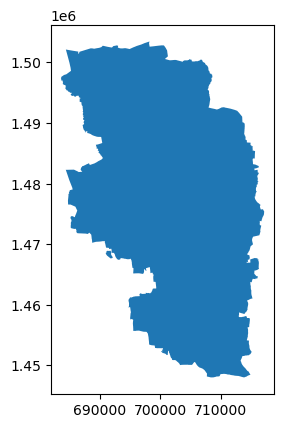

In [10]:
Gubbi_taluk.plot()

In [11]:
Gubbi_taluk.crs

<Derived Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
date_range = '2024-05-01/2024-07-01'

In [13]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime = date_range,
    intersects=shapely.geometry.box(*Gubbi_taluk.to_crs(4326).total_bounds),
    query = ['eo:cloud_cover<10'],
    )

In [15]:
# get all items
items_dict = [i.to_dict() for i in search.items()]
print(f"{len(items_dict)} scenes fetched")

8 scenes fetched


In [16]:
stack = stackstac.stack(items_dict, ['B02','B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12'],fill_value=0, dtype="uint16",resolution=10,resampling=Resampling.lanczos)
stack

,Array,Chunk
Bytes,72.14 GiB,2.00 MiB
Shape,"(8, 11, 20982, 20976)","(1, 1, 1024, 1024)"
Count,38984 Tasks,38808 Chunks
Type,uint16,numpy.ndarray


In [17]:
cliped = stack.rio.clip_box(*Gubbi_taluk.total_bounds,crs= Gubbi_taluk.crs).to_dataset(dim='band')

In [18]:
cliped.isel(time=slice(3,7)).max(dim='time').astype(np.uint16).to_array().rio.to_raster('fcc_3.tif')